In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.externals import joblib

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_colwidth', 400)

# Load Data

In [3]:
df = pd.read_csv("data/items.csv") # df with items per order
df_orders = pd.read_csv("data/order_churn_data.csv") # df with orders per customer
df = df.merge(df_orders[["customer_db_id", "email", "order_id", "aov",
                         "order_state", "order_created_datetime", "frequency"]])

df = df.loc[df.order_state == "completed"] # only get completed orders, to make sure they are itemized

# Product Processing

## Group Products Names by Similarity

In [5]:
df_products = pd.read_csv("data/products.csv") # df with IDs and english names for all products
unique_prods = df_products.product_name.sort_values().unique().tolist()

In [6]:
len(unique_prods)

397

In [7]:
unique_prods

['#FINILALESSIVE Blouse',
 '#FINILALESSIVE Shirt (on hanger)',
 '#LAUNDRYLIBERATION SPECIAL Blouse',
 '#LAUNDRYLIBERATION SPECIAL Shirt (on hanger)',
 '#WÄSCHEREVOLUTION Blouse',
 '#WÄSCHEREVOLUTION Shirt (on hanger)',
 "1 Suit (2 pieces), 10 Men's Shirts on a hanger & 1 Tie",
 "10 Men's Shirt (on hanger) Bundle",
 '10 Shirt (On Hanger) Bundle',
 '10 Shirts (On Hanger) Bundle',
 '10 Shirts (on hanger)',
 '10 shirts on hanger',
 '10 t-shirts',
 "11 Men's Shirt (on hanger) Bundle",
 '11 Shirts (On Hanger) Bundle',
 '11 shirts bundle',
 '12 Blouse Bundle',
 "12 Men's Shirt (on hanger) Bundle",
 '12 Shirt (On Hanger) Bundle',
 '12 Trouser Bundle',
 '12 shirts bundle',
 "13 Men's Shirt (on hanger) Bundle",
 '13 Shirt (On Hanger) Bundle',
 '13 shirts bundle',
 "14 Men's Shirt (on hanger) Bundle",
 '14 Shirt (On Hanger) Bundle',
 '14 shirts bundle',
 '15 Blouse Bundle',
 "15 Men's Shirt (on hanger) Bundle",
 '15 Shirt (On Hanger) Bundle',
 '15 Trouser Bundle',
 '15 shirts bundle',
 "16 Men's 

Load itemization data from:
- https://docs.google.com/spreadsheets/d/1bWyhdLxkGqO6MsCuwc6aaj5ZIPTVXG14AJ_sOKh2-gQ/edit?usp=sharing

This sheet was manually created and contains *product_types* and *product_groups*. The unique product names should be grouped to product types based on character similarity, while the product types are groupe to product_groups manually.

In [9]:
df_itemization = pd.read_csv("data/itemization.csv") 
df_itemization['product_type_sort'] = df_itemization.product_type_category + '_' + df_itemization.product_type
product_types = df_itemization.product_type.unique().tolist()
df_itemization.head(10)

,product_type,product_group,product_type_category,product_type_sort
0,Apron,HH_others,HH,HH_Apron
1,Bathmat,HH_others,HH,HH_Bathmat
2,Bathrobe,HH_others,HH,HH_Bathrobe
3,Bed linen Bed bundle Bedding bundle Big Bed,HH_linens,HH,HH_Bed linen Bed bundle Bedding bundle Big Bed
4,Bedsheets,HH_linens,HH,HH_Bedsheets
5,Bedspread,HH_blanket,HH,HH_Bedspread
6,Belt,Accessories,ACC,ACC_Belt
7,Blanket,HH_blanket,HH,HH_Blanket
8,Blazer,BUS_Blazer,BUS,BUS_Blazer
9,Blouse,BUS_Blouse,LAD,LAD_Blouse


## Vectorizer to identify product type
The unique product names from DB are grouped based on text similarity, to reduce the number of products. E.g: *10x shirt bundle* and *shirt* and *shirts* should be the same product_type.

In [10]:
vectorizer = CountVectorizer(unique_prods, ngram_range=(3,5), analyzer='char')
vectorizer.fit(unique_prods)
X = vectorizer.transform(unique_prods).toarray()
y = vectorizer.transform(product_types).toarray()

In [11]:
similarities = cosine_similarity(X, y)
similarities.shape

(397, 50)

## Product Types
For each product name from the DB, the best match product_type in terms of similarity is chosen.

In [12]:
best_matches = similarities.argmax(axis=1)

In [13]:
df_products = pd.DataFrame(data=list(zip(unique_prods, best_matches)), columns=['product_name', 'best_match'])
df_products['product_type'] = df_products['best_match'].apply(lambda x: product_types[x])
df_products[['product_name', 'product_type']].sort_values('product_name').to_csv('data/test_products.csv', index=False)
df_products.groupby(['product_type'])['product_name'].apply(lambda x: ' | '.join(x)).reset_index()

,product_type,product_name
0,Apron,Apron | Unprocessed test
1,Bathmat,Bath mat
2,Bathrobe,Bathrobe | bathrobe
3,Bed linen Bed bundle Bedding bundle Big Bed,2 Suit Bundle | 2 Suits Bundle | 3 Suit Bundle | Bed and Linen King Bundle | Bedding Bundle | Berlin City Bundle | bedding bundle
4,Bedsheets,Bed sheet | Bedsheet | Bedsheet (double/king/superking) | Bedsheet (single) | Bedsheet - Double (72 hours) | Bedsheet - King (72 hours) | Bedsheet - Single (72 hours) | Bedsheet - Super King (72 hours)
5,Bedspread,Bedspread | Bedspread (double/king/superking) | Bedspread (single) | Bedspread - Double (72 hours) | Bedspread - King (72 hours) | Bedspread - Single (72 hours) | Bedspread - Super King (72 hours) | Bedspread - king | Bedspread - large (from 1.20 m in width) | Bedspread - small (up to 1.20 m in width) | Bedspread - super king
6,Belt,Belt
7,Blanket,"Blanket | Blanket (feather) - large (from 1,40m in width) | Blanket (feather) - small (up to 1,40m in width) | Blanket - large (from 1.40 m in width) | Blanket - small (up to 1.40 m in width)"
8,Blazer,Blazer | Blazer (linen) | Blazer / Jacket | Blazer / Jacket - linen
9,Blouse,"#FINILALESSIVE Blouse | #LAUNDRYLIBERATION SPECIAL Blouse | #WÄSCHEREVOLUTION Blouse | 12 Blouse Bundle | 15 Blouse Bundle | 18 Blouse Bundle | 2 Blouses | 21 Blouse Bundle | 24 Blouse Bundle | 27 Blouse Bundle | 3 Blouse Bundle | 3 Blouses | 3 Blouses Bundle | 30 Blouse Bundle | 5 Blouse Bundle (no silk) | 6 Blouse Bundle | 9 Blouse Bundle | Blouse (no silk, hand ironed) | Blouse - silk (han..."


In [14]:
df_products = df_products.merge(df_itemization, on='product_type')

In [15]:
df = df.merge(df_products, how='left', on='product_name')

# Cluster Customer based on Product Groups
Each product_type belongs to a product_group. We want to find clusters of customers who order the same product_groups.

### Prepare Data

In [21]:
# for each customer and product_group get how many orders this group was included in and in what quantity
df_cust = df.groupby(['customer_db_id', 'product_group'])\
            .agg({'quantity': 'sum', 'order_id': 'nunique', 'frequency': 'min'})\
            .reset_index()\
            .set_index('customer_db_id')

In [22]:
df_cust.head()

,product_group,quantity,order_id,frequency
customer_db_id,,,,
54478fa4d3cde8d17ca5e4db,BUS_Blazer,1.0,1,0.000000
54478fa4d3cde8d17ca5e4db,BUS_Shirt,7.0,1,0.000000
545b9a8bd2cde8871f009f9b,BUS_Shirt,121.0,7,103.625000
545bf6e0d4cde8f935b78a08,BUS_Blazer,5.0,5,12.454545
545bf6e0d4cde8f935b78a08,BUS_Dress,3.0,2,12.454545


In [24]:
# get dummy values of customers and product_groups
df_dumm = pd.get_dummies(df_cust['product_group'])
# group all dummies for one customer into one row
df_dumm = df_dumm.reset_index().groupby(['customer_db_id']).max()
df_dumm.head()

,Accessories,BUS_Blazer,BUS_Blouse,BUS_Dress,BUS_Evening Dress,BUS_Shirt,BUS_Skirt,BUS_Suit,BUS_Trousers,CAS_Knitwear,...,HH_covers,HH_cushions,HH_linens,HH_others,HH_pillow_case,HH_towels,OUT_Jackets + Coats,OUT_Skiwear,Others,WashFold
customer_db_id,,,,,,,,,,,,,,,,,,,,,
54478fa4d3cde8d17ca5e4db,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
545b9a8bd2cde8871f009f9b,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
545bf6e0d4cde8f935b78a08,0,1,0,1,0,1,0,1,1,0,...,0,0,1,0,1,0,0,0,0,1
545e000cd4cde8f150245542,1,1,1,1,0,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
5460b54cd3cde8e8394e5f76,0,0,0,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


### Train K-Means clustering

In [25]:
# X = df_dumm.values
# m_km = KMeans(n_clusters=10)
# m_km.fit(X)
# m_clusters = m_km.labels_.tolist()

In [26]:
# joblib.dump(m_km, 'data/models/best_items_clf.pkl') 
m_km = joblib.load('data/models/best_items_clf.pkl') 
m_clusters = m_km.labels_.tolist()

In [27]:
df_clustered = df_dumm.copy()
df_clustered['cluster'] = m_clusters

In [28]:
cluster_names = {0: 'Shirt+Trousers', 
                 1: 'Shirt+Trousers+Suit+Blazer',
                 2: 'Shirt',
                 3: 'WashFold',
                 4: 'Suit+Shirt',
                 5: 'Jackets+Coats',
                 6: 'Suit',
                 7: 'Dress+Blouse+Skirt+Top',
                 8: 'Mix',
                 9: 'Household'}
df_clustered['cluster_name'] = df_clustered.cluster.map(cluster_names)

In [31]:
df_clustered.groupby(['cluster_name'])['Accessories'].count().sort_values()

cluster_name
Household                      2228
Mix                            2831
Shirt+Trousers+Suit+Blazer     3359
Dress+Blouse+Skirt+Top         4082
Shirt+Trousers                 4994
Jackets+Coats                  5005
Suit                           7098
Suit+Shirt                     7558
Shirt                          7736
WashFold                      10697
Name: Accessories, dtype: int64

### Get average frequency per cluster

In [32]:
df_clustered = df_clustered.join(df.groupby('customer_db_id')['frequency'].mean())

In [33]:
df_avg_freq = df_clustered.loc[df_clustered.frequency > 0]\
                .groupby('cluster_name')\
                .agg({'frequency': ['mean', 'median']})\
                .reset_index()
df_avg_freq.columns = df_avg_freq.columns.droplevel()
df_avg_freq.columns = ['cluster_name', 'freq_mean', 'freq_median']
df_avg_freq

,cluster_name,freq_mean,freq_median
0,Dress+Blouse+Skirt+Top,104.144664,69.000000
1,Household,61.998914,35.055556
2,Jackets+Coats,135.013028,83.000000
3,Mix,52.450889,33.777778
4,Shirt,70.986182,37.000000
5,Shirt+Trousers,72.184717,37.000000
6,Shirt+Trousers+Suit+Blazer,88.579537,57.333333
7,Suit,120.691093,80.000000
8,Suit+Shirt,82.303215,47.000000
9,WashFold,68.554047,29.000000


In [34]:
df_clustered = df_clustered.reset_index().merge(df_avg_freq, on='cluster_name')

In [35]:
df_clustered.to_csv('data/clustered_customers.csv')

### Plot cluster centers and avg frequencies

In [29]:
centers = pd.DataFrame(data=m_km.cluster_centers_, columns=df_dumm.columns)
centers.index = centers.index.map(cluster_names)

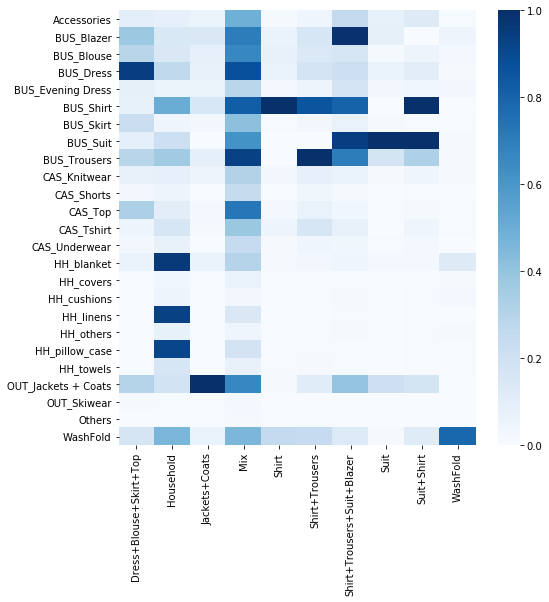

In [30]:
centers.head()
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(centers.sort_index().T, cmap='Blues')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

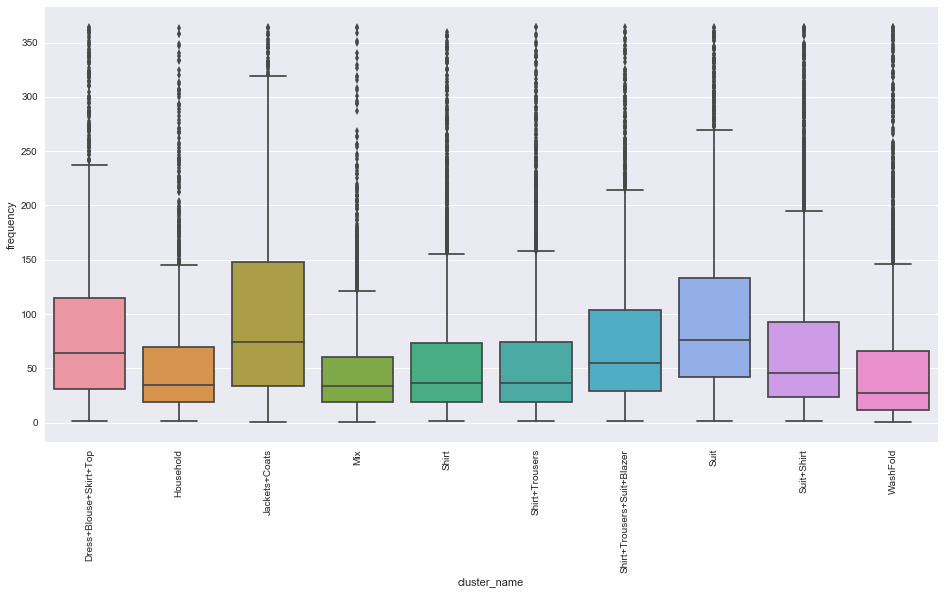

In [36]:
fig = plt.figure(figsize=(16,8))
sns.set()
sns.categorical.boxplot(data=df_clustered.loc[(df_clustered.frequency < 365) & (df_clustered.frequency > 0)], 
                           x='cluster_name', y='frequency',
                           order=sorted(df_clustered.cluster_name.unique().tolist()))
plt.xticks(rotation=90)

# NPS

In [ ]:
df_nps = pd.read_csv("data/NPS.csv")
df_nps = df_nps[['email', 'How often do you use a dry cleaner and/or launderette?', 'file']]
df_nps.columns = ['email', 'NPS_frequency', 'file']

translations = {'Toutes les deux semaines': 'Bi-Weekly',
               'Chaque mois': 'Monthly',
               'Moins que chaque trimestre': 'Less than quarterly',
               'Chaque trimestre': 'Quarterly',
               'Chaque semaine': 'Weekly',
               'Weniger oft': 'Less than quarterly',
               'VierteljÃ¤hrlich': 'Quarterly',
               'ZweiwÃ¶chentlich': 'Bi-Weekly',
               'Monatlich': 'Monthly',
               'WÃ¶chentlich': 'Weekly'}

sorting = {'Weekly': '0_Weekly',
          'Bi-Weekly': '1_Bi-Weekly',
          'Monthly': '2_Monthly',
          'Quarterly': '3_Quarterly',
          'Less than quarterly': '4_Less than quarterly'}

df_nps.loc[df_nps.file.isin(['DE.csv', 'FR.csv']), 'NPS_frequency'] = df_nps.NPS_frequency.map(translations)
df_nps.NPS_frequency = df_nps.NPS_frequency.map(sorting)
df_nps = df_nps[['email', 'NPS_frequency']]

In [ ]:
df_nps_cluster = df_clustered.groupby(['cluster', 'NPS_frequency'])['customer_db_id'].nunique().reset_index()
df_nps_cluster_total = df_clustered.loc[~df_clustered.NPS_frequency.isnull()]\
                                    .groupby(['cluster'])['customer_db_id'].nunique()\
                                    .reset_index().rename(columns={'customer_db_id': 'cluster_total'})
df_nps_cluster = df_nps_cluster.merge(df_nps_cluster_total, how='left', on='cluster')
df_nps_cluster['cluster_freq'] = df_nps_cluster.customer_db_id / df_nps_cluster.cluster_total

In [ ]:
df_nps_cluster_pivot = df_nps_cluster.pivot(index='NPS_frequency', columns='cluster', values='cluster_freq')
sns.heatmap(df_nps_cluster_pivot, cmap='Greens')

In [ ]:
# df_clustered.to_csv('data/clustered_customers.csv', index=False)

In [ ]:
df = df.merge(df_clustered.reset_index()[['customer_db_id', 'cluster']], on='customer_db_id', how='left')

In [ ]:
df.groupby('cluster')['aov'].describe()

In [ ]:
df_nps_products = df.loc[~df.NPS_frequency.isnull()]\
                    .groupby(['NPS_frequency', 'product_group'])['customer_db_id']\
                    .nunique().reset_index()
df_nps_products_total = df.loc[~df.NPS_frequency.isnull()]\
                    .groupby(['product_group'])['customer_db_id']\
                    .nunique().reset_index()\
                    .rename(columns={'customer_db_id': 'product_group_total'})
df_nps_products = df_nps_products.merge(df_nps_products_total, on='product_group', how='left')
df_nps_products['customers_ratio'] = df_nps_products.customer_db_id / df_nps_products.product_group_total
df_nps_products.head()

In [ ]:
df_nps_products_pivot = df_nps_products.pivot(index='product_group', columns='NPS_frequency', values='customer_db_id')

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(df_nps_products_pivot, cmap='Greens', yticklabels=df_nps_products_pivot.index)